# Camo Worms Genetic Algorithm

In [124]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images

In [126]:
# Global variables

pop_size = 6
epochs = 3

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

In [127]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)

In [128]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


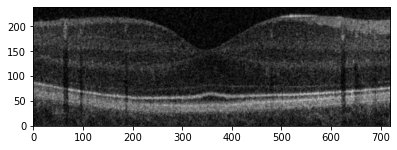

In [111]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

class Instance:
    def __init__(self):
        self.cost = None
        self.clew = None
        self.drawing = None
        self.rng = np.random.default_rng()  # Random number generator

    def random_worm(self, imshape, init_params):
        (radius_std, deviation_std, width_theta) = init_params
        (ylim, xlim) = imshape
        midx = xlim * self.rng.random()
        midy = ylim * self.rng.random()
        r = radius_std * np.abs(self.rng.standard_normal())
        theta = self.rng.random() * np.pi
        dr = deviation_std * np.abs(self.rng.standard_normal())
        dgamma = self.rng.random() * np.pi
        colour = self.rng.random()
        width = width_theta * self.rng.standard_gamma(3)
        return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

    def create_instance(self, image, clews=None):
        if clews:
            self.clew = clews
        else:
            self.clew = self._initialise_clew(40, image.shape, (40, 30, 1))

        self.drawing = Drawing(image)
        self.drawing.add_worms(self.clew)
        return self.drawing

    def show_instance(self):
        if self.drawing:
            self.drawing.show()

    def _initialise_clew(self, size, imshape, init_params):
        clew = []
        for i in range(size):
            clew.append(self.random_worm(imshape, init_params))
        return clew

    def calculate_cost(self):
        return -1


In [85]:
# This class is used for randomly initialising an image with worms
class Instance:
    def __init__(self):
        self.cost = None
        self.clew = None
        self.drawing = None


    def random_worm (self, imshape, init_params):
        (radius_std, deviation_std, width_theta) = init_params
        (ylim, xlim) = imshape
        midx = xlim * rng.random()
        midy = ylim * rng.random()
        r = radius_std * np.abs(rng.standard_normal())
        theta = rng.random() * np.pi
        dr = deviation_std * np.abs(rng.standard_normal())
        dgamma = rng.random() * np.pi
        colour = rng.random()
        width = width_theta * rng.standard_gamma(3)
        return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

    def create_instance(self, image, clews=None):
        if clews:
            self.clew = clews
        else:
            self.clew = self._initialise_clew(40, image.shape, (40, 30, 1))

        self.drawing = Drawing(image)
        self.drawing.add_worms(self.clew)
        return self.drawing

    # FIX: This doesn't work, not sure why yet
    def show_instance(self):
        self.drawing.show()

    def _initialise_clew(self, size, imshape, init_params):
        clew = []

        for i in range(size):
            clew.append(random_worm(imshape, init_params))

        return clew
    def calculate_cost():
        return -1

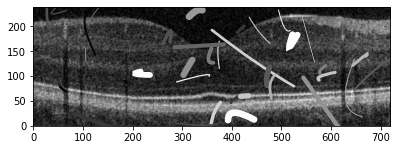

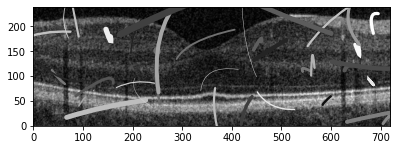

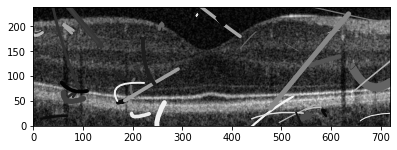

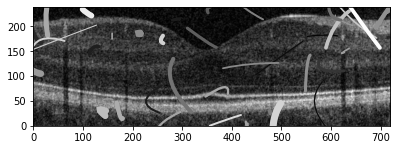

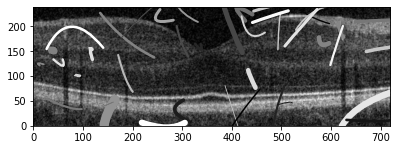

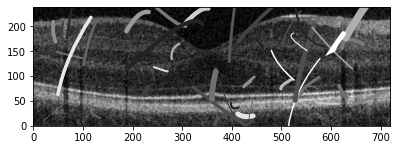

In [129]:
# This will be a series of the same image with different worm initialisations

def init_population(image):
    # Could potentially add logic to get more favourable population initialisation
    # For example manually adjusting worms to favourable positions??
    population = []

    for _ in range(pop_size):

        instance = Instance()
        instance.create_instance(image)
        population.append(instance)

    return population

population = init_population(image)




In [134]:
import random

class Genetic_Algorithm:

    def tournament_select(self, population, tournament_size=3):
        # 1) Select k individuals from the population
        tournament = random.sample(population, tournament_size)

        # 2) TODO: Select individual with optimal cost

        # 3) Return that individual.
        return tournament[0]

    def crossover(self, parent_1, parent_2):
        # TODO: Need to implement the logic for this, potentially discuss multiple crossover
        # Take half of one parent and other half of other
        Instance().create_instance(image, parent_1.clew)
        Instance().create_instance(image, parent_2.clew)
        first_half = parent_1.clew[:len(parent_1.clew) // 2]
        second_half = parent_2.clew[len(parent_2.clew) // 2:len(parent_2.clew)]
        clews = first_half + second_half
        child = Instance()
        child.create_instance(image, clews)

        return child

    def mutation(self, instance):
        # TODO: Implement logic for mutation instance
        # Add random small value to each worm??
        return instance

    def run_genetic_algorithm(self, population, epochs, mutation_rate=0.1):

        for i in range(epochs):
            new_pop = []

            while len(new_pop) < len(population):
                # Determine parents
                parent_1 = self.tournament_select(population)
                parent_2 = self.tournament_select(population)

                # Apply crossover
                child = self.crossover(parent_1, parent_2)

                # Each child has a 10% chance of mutation being applied
                if random.random() < mutation_rate:
                    child = self.mutation(child)

                new_pop.append(child)

            population = new_pop

        # Need to add data recording for graphs at some point - maybe track the fitness and images every X amount of epochs
        # Return the most optimal solution from the population
        return population[0]





/tmp/ipykernel_7123/2490856956.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.ax = plt.subplots()


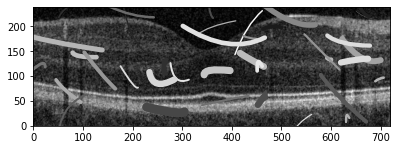

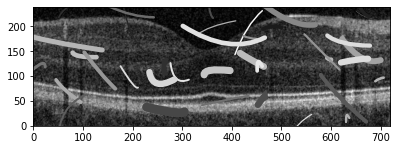

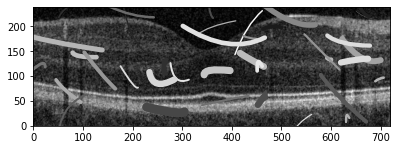

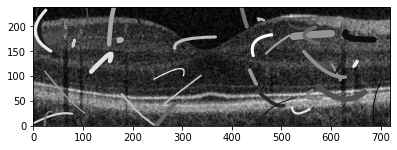

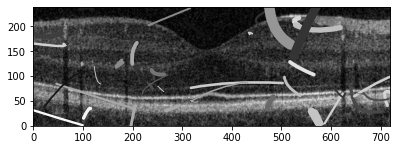

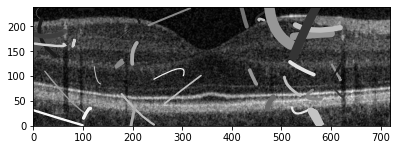

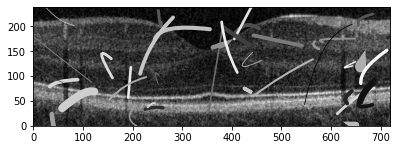

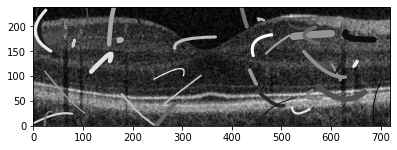

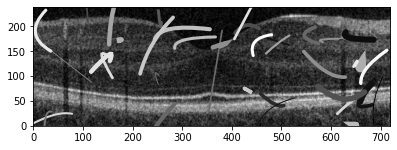

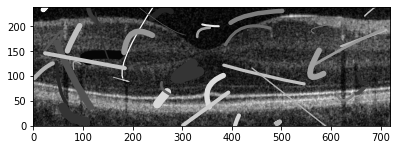

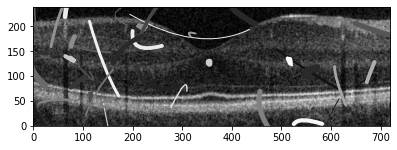

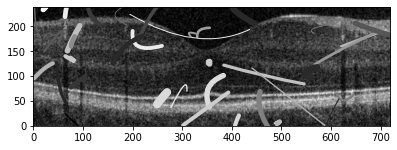

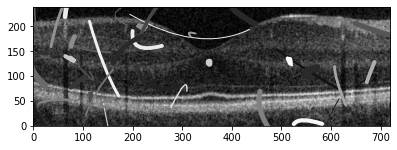

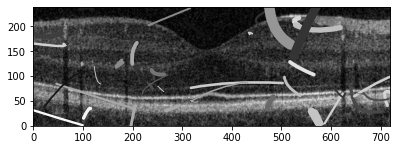

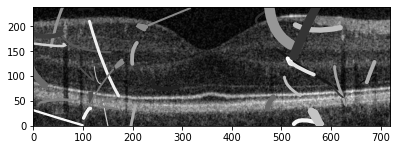

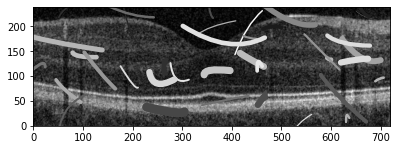

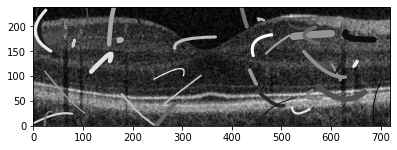

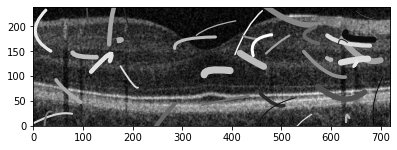

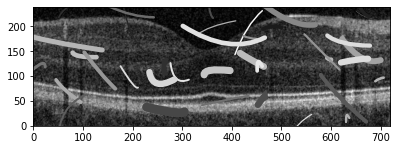

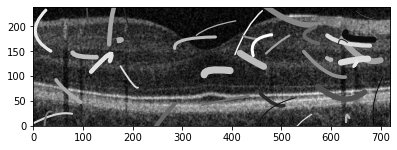

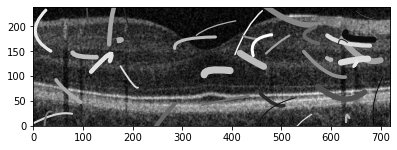

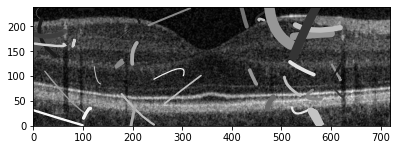

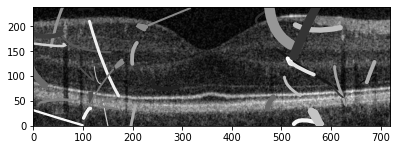

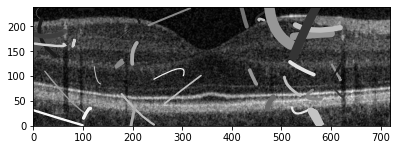

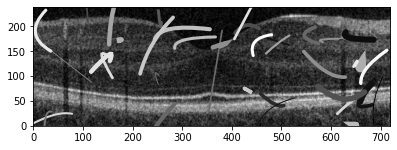

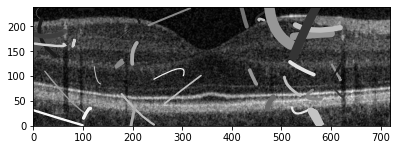

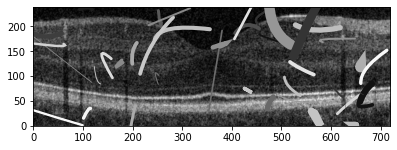

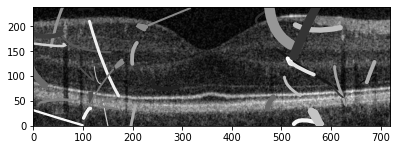

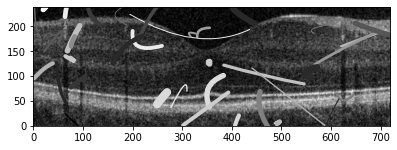

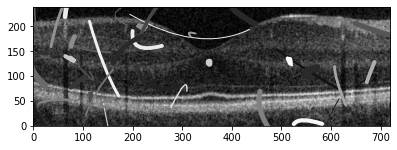

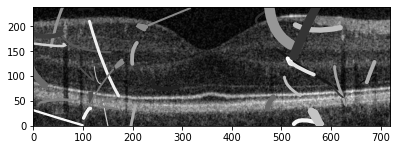

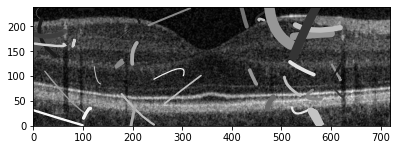

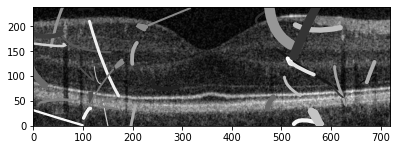

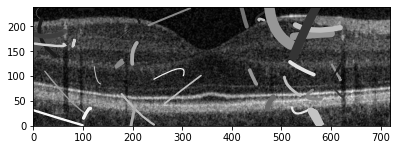

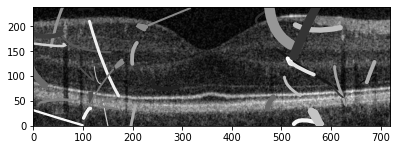

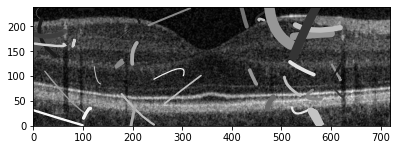

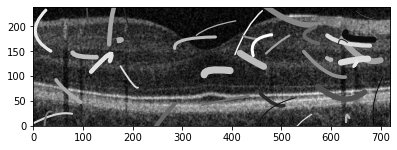

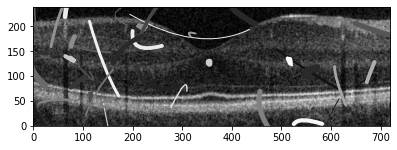

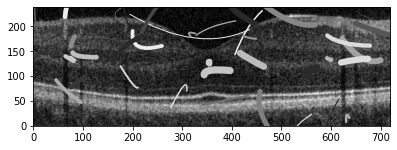

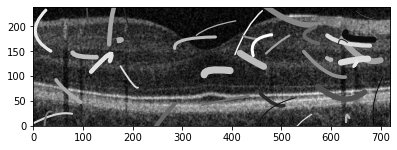

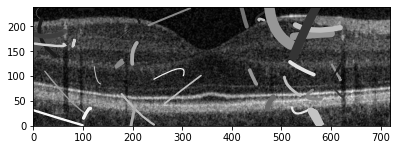

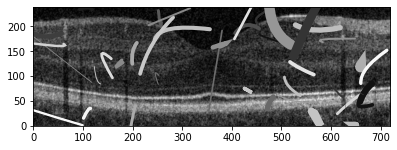

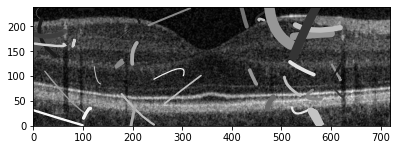

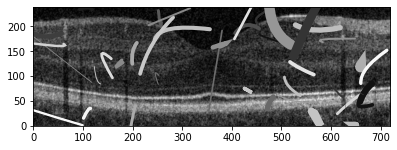

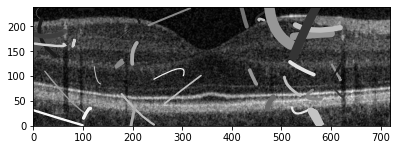

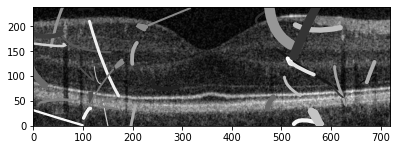

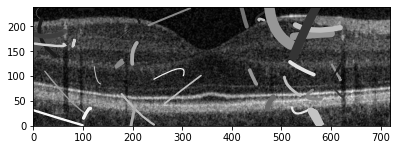

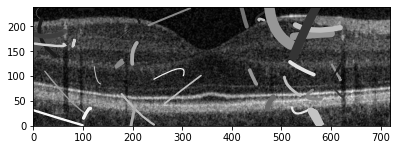

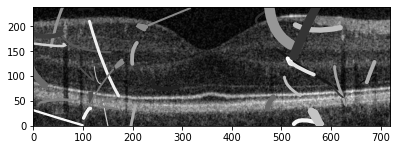

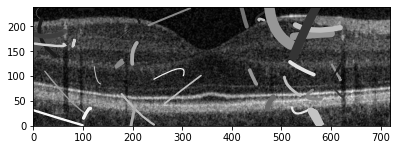

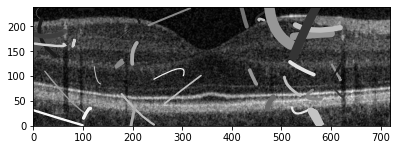

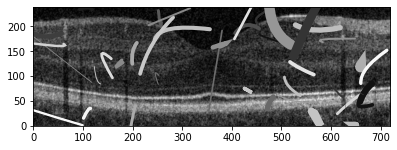

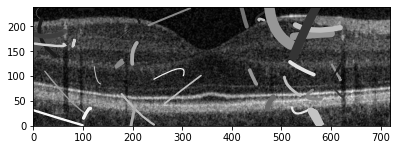

In [117]:
ga = Genetic_Algorithm()
ga.run_genetic_algorithm(population, epochs)